In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

In [27]:
%watermark -n -u -v -iv -w

Last updated: Sat Jun 04 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.3.0

arviz     : 0.12.1
numpy     : 1.22.4
matplotlib: 3.5.2
pymc      : 4.0.0b1
scipy     : 1.7.3
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]

Watermark: 2.3.0



In [3]:
stats.binom.cdf(4, n=9, p=0.5)

0.5

Ch 2 grid approximation

In [4]:
pts, x, n = 100, 6, 9
p_grid = np.linspace(0,1,pts)
pr = np.repeat(1,pts)
L = stats.binom.pmf(x, n, p_grid)
upos = L * pr
pos = upos / upos.sum()


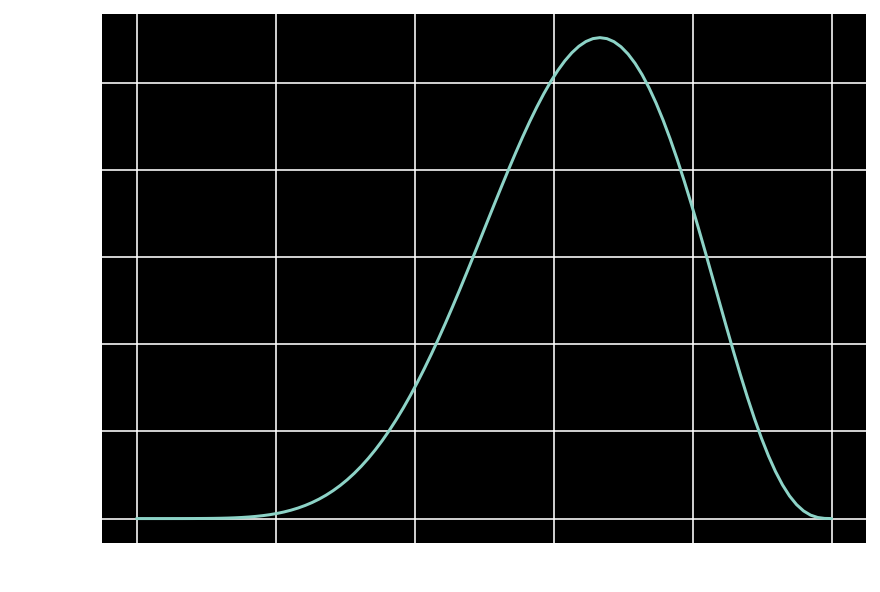

In [5]:
plt.plot(p_grid,pos)

Quadratic approx with pymc

In [6]:
with pm.Model() as quap:
    p = pm.Uniform("p", 0, 1)
    w = pm.Binomial("w", n=9, p=p, observed=6)
    mean_q = pm.find_MAP()

mean_q

{'p': array(0.66666667), 'p_interval__': array(0.69314718)}

Ch 3 sampling from posterior

np.random.choice() is equivalent to R sample()

In [7]:
samples = np.random.choice(p_grid, p=pos, size=10000, replace=True)

<AxesSubplot:>

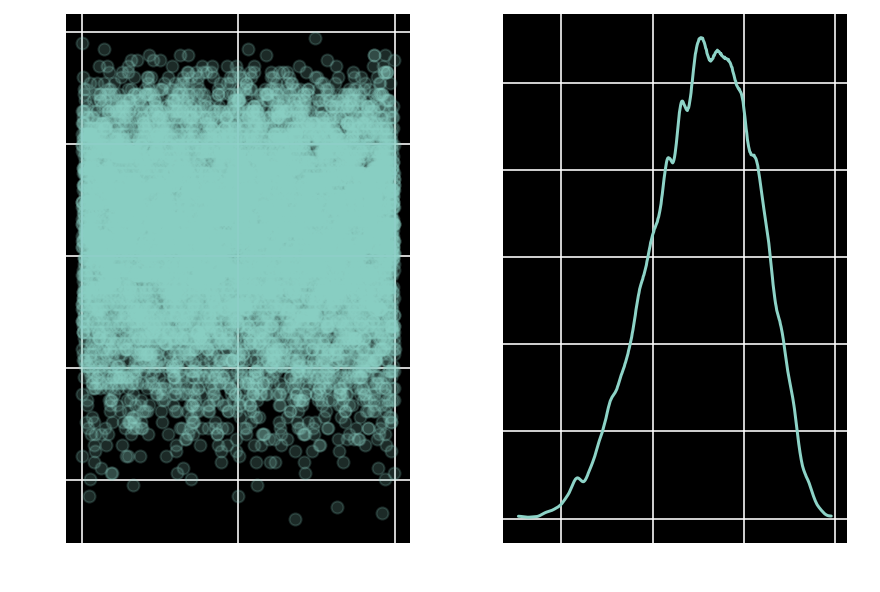

In [8]:
_, (ax0, ax1) = plt.subplots(1, 2)
ax0.plot(samples, "o", alpha=0.2)
az.plot_kde(samples)

In [9]:
np.quantile(samples, [0.1,0.9])

array([0.45454545, 0.81818182])

In [10]:
sum((samples > 0.4545454) & (samples < 0.8080808)) / len(samples)

0.7817

(array([  22.,  120.,  356.,  749., 1263., 1749., 1999., 1856., 1305.,
         581.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

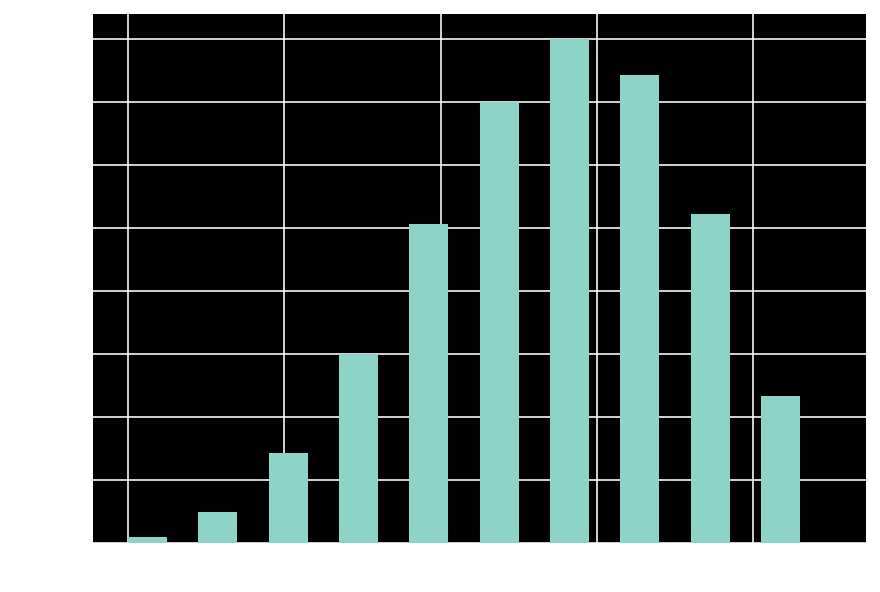

In [11]:
posterior_predictive = stats.binom.rvs(n=9,p=samples)
plt.hist(posterior_predictive, width=0.5)

histograms in matplotlib are weird

(array([  22.,  120.,  356.,  749., 1263., 1749., 1999., 1856., 1305.,
         581.]),
 array([-0.25,  0.75,  1.75,  2.75,  3.75,  4.75,  5.75,  6.75,  7.75,
         8.75,  9.75]),
 <BarContainer object of 10 artists>)

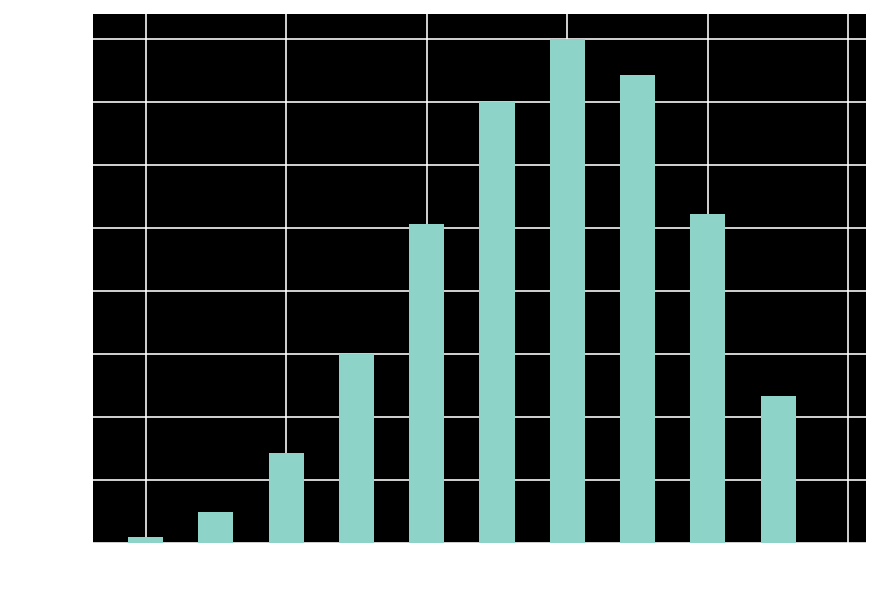

In [12]:
plt.hist(posterior_predictive, bins=np.arange(0, 11) - 0.5/2 , width=0.5)


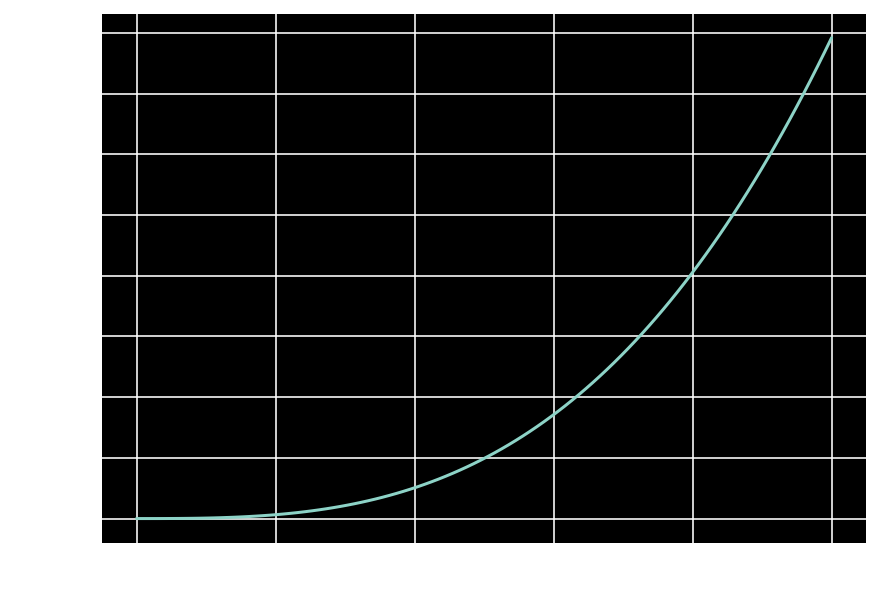

In [13]:
pts, x, n = 100, 3, 3
p_grid = np.linspace(0,1,pts)
pr = np.repeat(1,pts)
L = stats.binom.pmf(x, n, p_grid)
upos = L * pr
pos = upos / upos.sum()
plt.plot(p_grid,pos)

In [14]:
samples = np.random.choice(p_grid, p=pos, size=10000, replace=True)
np.quantile(samples, [0.25,0.75])

array([0.71717172, 0.93939394])

In [15]:
az.hdi(samples, 0.5)

array([0.84848485, 1.        ])

In [16]:
np.median(samples), np.mean(samples), stats.mode(samples)

(0.8484848484848485,
 0.8058323232323233,
 ModeResult(mode=array([1.]), count=array([392])))

In [17]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

.rvs  random values

In [18]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 2, 2, 2, 1, 2, 1, 1, 1, 1])

(array([ 286., 1079., 2814., 5821.]),
 array([-0.05,  0.95,  1.95,  2.95,  3.95]),
 <BarContainer object of 4 artists>)

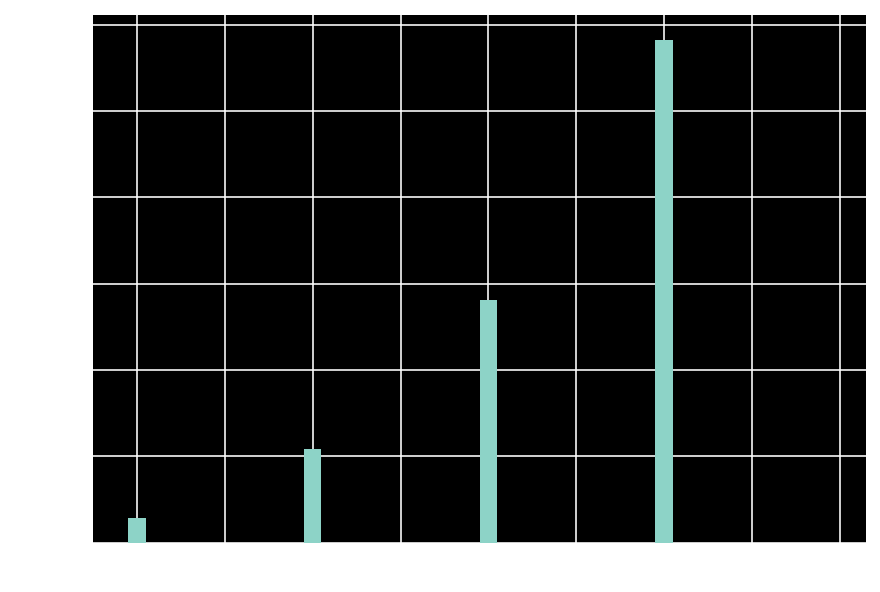

In [19]:
posterior_predictive = stats.binom.rvs(n=3, p=samples)
plt.hist(posterior_predictive, bins=np.arange(0,5)-0.05,  width=0.1)

ch 4. Instead of replicate, make a matrix in numpy and apply a function across a specified dimension

In [20]:
x = np.random.uniform(-1,1, size=(5, 10))
x

array([[ 0.0862461 ,  0.29561276, -0.20004591,  0.34485049,  0.47509502,
        -0.45802466,  0.66796317, -0.28580983,  0.12664967,  0.91820952],
       [-0.34135937, -0.83566674,  0.97740801,  0.35595241, -0.3715174 ,
        -0.23093362, -0.91700158, -0.29058425,  0.4003408 , -0.01277543],
       [-0.57485665, -0.67772486, -0.40482956, -0.16918789, -0.75209396,
        -0.44941036,  0.33869609,  0.94333565, -0.11417791,  0.11868489],
       [-0.63142578, -0.62925171,  0.66294313,  0.47200491,  0.71794924,
         0.805629  , -0.52104458, -0.45727275,  0.09752018,  0.17941626],
       [-0.43266176, -0.01970438,  0.9877499 , -0.32106564, -0.74851903,
        -0.2372504 , -0.81393182,  0.89739496,  0.8064959 ,  0.79518587]])

In [21]:
x.sum(0)

array([-1.89405746, -1.86673494,  2.02322558,  0.68255427, -0.67908613,
       -0.56999004, -1.24531873,  0.80706379,  1.31682862,  1.99872111])

In [22]:
x.sum(1)

array([ 1.97074633, -1.26613717, -1.74156456,  0.6964679 ,  0.91369359])

<AxesSubplot:>

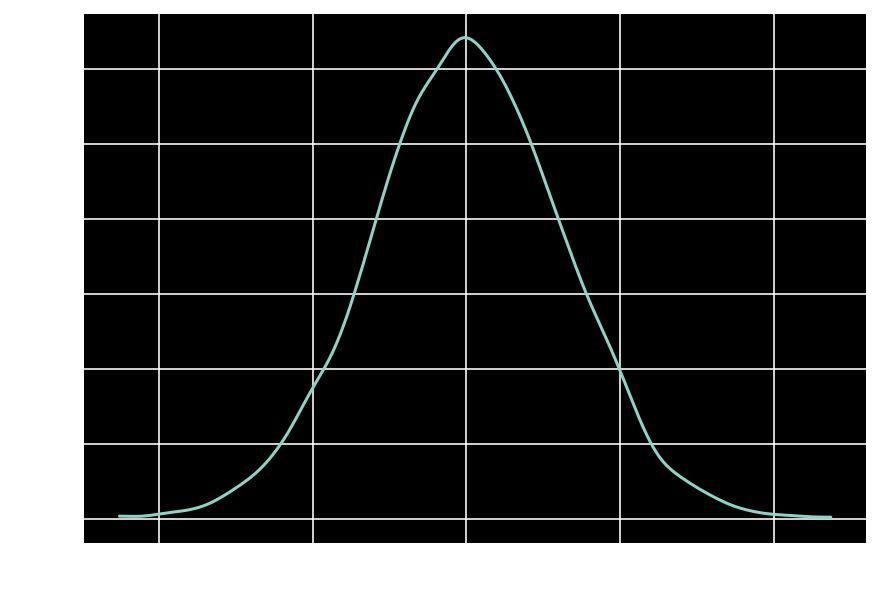

In [23]:
reps = 10000
n = 30
x = np.random.uniform(-1,1, size=(n,reps))
az.plot_kde(x.sum(0))

ax tells az where to plot

<AxesSubplot:>

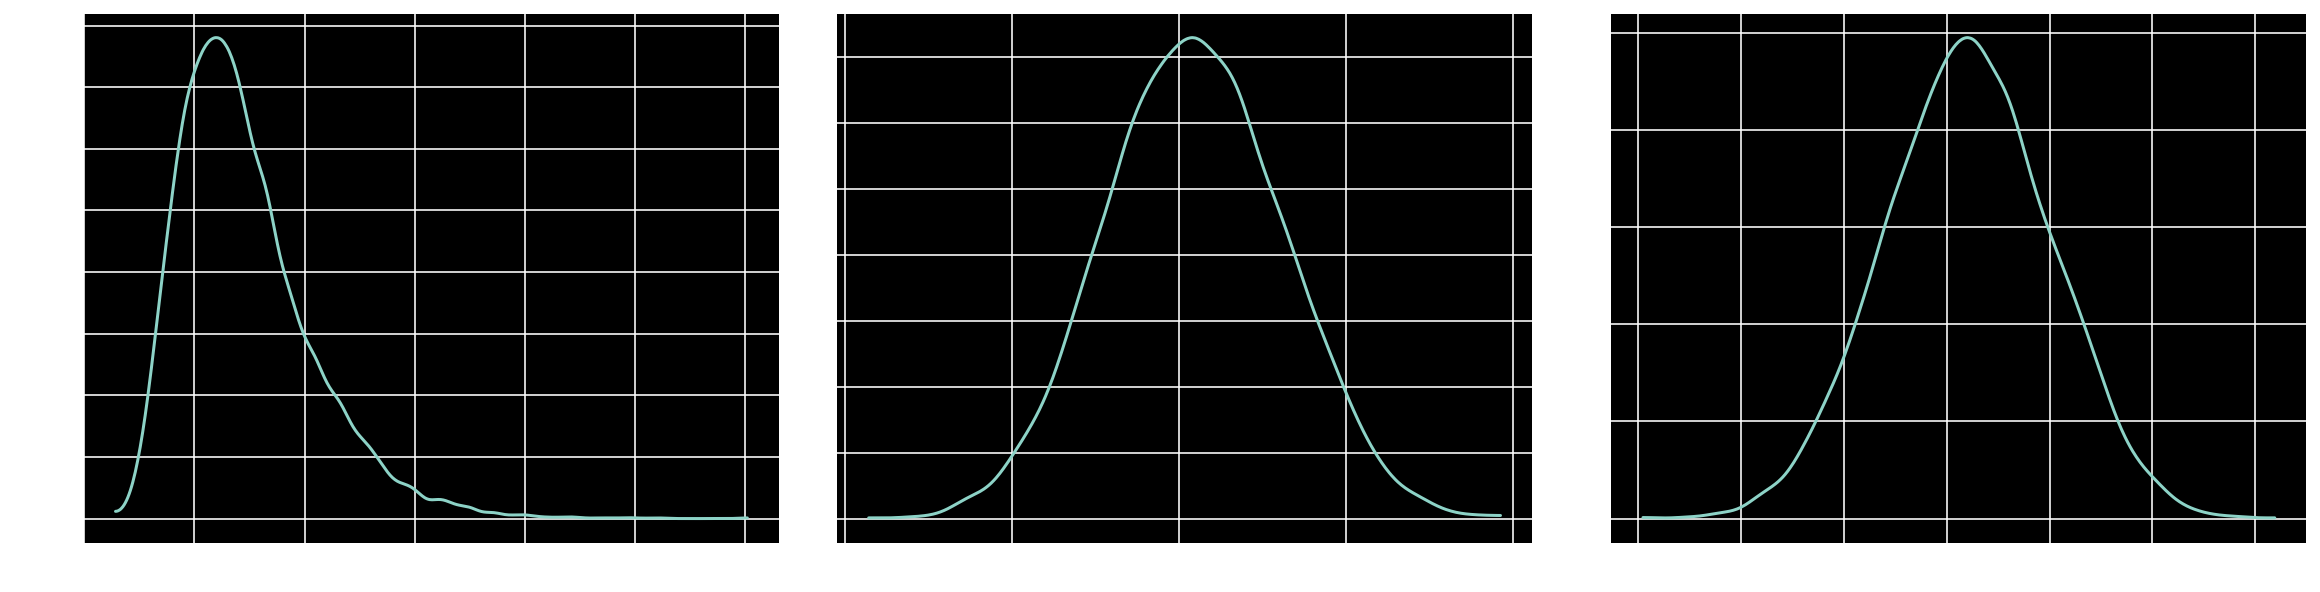

In [24]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 3, figsize=(16, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1])
az.plot_kde(np.log(big), ax=ax[2])